<a href="https://colab.research.google.com/github/manishmawatwal/DataScience/blob/main/StockMovementClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
#Description: Use stock indicators with Machine Learning to predict stock price

In [2]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from pandas_datareader import data as web
import requests
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from bokeh.plotting import figure, show

In [3]:
#get stock symbol/tickers in the portfolio
stockSymbols = ['GOOG', 'TSLA', 'NFLX']
#get the stock/portfolio starting date
stockStartDate = '2013-01-01'
#get the ending date in the format YYYY-mm-dd / today's date
today = datetime.today().strftime('%Y-%m-%d')
#create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

In [4]:
#get the number of assets in the portfolio
numAssets = len(stockSymbols)
#print('You have '+str(numAssets)+' assets in your portfolio')

In [5]:
#create function to get the stock price in the portfolio
def getMyPortfolio(stocks = stockSymbols, start = stockStartDate, end = today, col='Adj Close'):
  data = web.DataReader(stocks, data_source = 'yahoo', start = start, end = end)[col]
  return data

#get the stock portfolio Adj Close Price
my_stocks = getMyPortfolio(stockSymbols)
my_stocks

Symbols,GOOG,TSLA,NFLX
Date,,,
2013-01-02,360.274597,7.072000,13.144286
2013-01-03,360.483826,6.954000,13.798571
2013-01-04,367.607117,6.880000,13.711429
2013-01-07,366.003143,6.868000,14.171429
2013-01-08,365.280823,6.736000,13.880000
...,...,...,...
2021-05-03,2395.169922,684.900024,509.109985
2021-05-04,2354.250000,673.599976,503.179993
2021-05-05,2356.739990,670.940002,496.079987


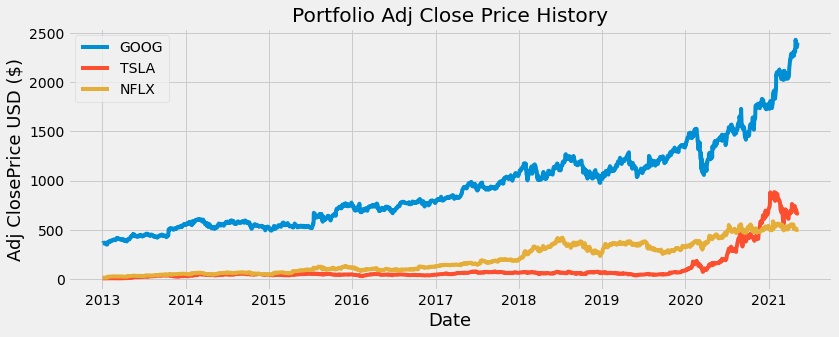

In [6]:
#create a function to visualize the portfolio
def showGraph(stocks = stockSymbols, start = stockStartDate, end = today, col = 'Adj Close'):
  #Create the title for the portfolio
  title = 'Portfolio '+col+' Price History'
  #get the stocks
  my_stocks = getMyPortfolio(stocks = stocks, start= start, end =end, col=col)
  #give the figure size
  plt.figure(figsize=(12.2, 4.5))
  #loop through each stock and plot the price
  for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label = c)
  plt.title(title)
  plt.xlabel('Date', fontsize = 18)
  plt.ylabel(col+'Price USD ($)', fontsize = 18)
  plt.legend(my_stocks.columns.values, loc = 'upper left')
  plt.show()

#show the adjusted close price
showGraph(stockSymbols)

In [7]:
#calculate and print the daily simple returns
daily_simple_returns = my_stocks.pct_change(1)
daily_simple_returns

Symbols,GOOG,TSLA,NFLX
Date,,,
2013-01-02,NaN,NaN,NaN
2013-01-03,0.000581,-0.016686,0.049777
2013-01-04,0.019760,-0.010641,-0.006315
2013-01-07,-0.004363,-0.001744,0.033549
2013-01-08,-0.001974,-0.019220,-0.020565
...,...,...,...
2021-05-03,-0.006203,-0.034591,-0.008491
2021-05-04,-0.017084,-0.016499,-0.011648
2021-05-05,0.001058,-0.003949,-0.014110


In [13]:
#show the daily simple stock correlation
daily_simple_returns.corr()
#create and show the annualized covariance matrix
daily_simple_returns.cov()
#show variance
daily_simple_returns.var()
#print the standard deviation for daily simple returns
daily_simple_returns.std()
#show the mean of daily simple return
daily_simple_returns.mean()

Symbols
GOOG    0.001034
TSLA    0.002800
NFLX    0.002139
dtype: float64

Text(0, 0.5, 'Daily simple returns')

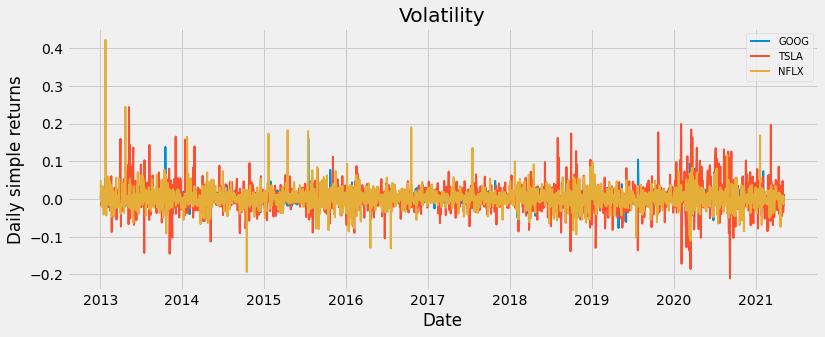

In [12]:
#visualize the stocks daily simple returns
plt.figure(figsize=(12,4.5))
#loop through each stock and plot the simple returns
for c in daily_simple_returns.columns.values:
  plt.plot(daily_simple_returns.index, daily_simple_returns[c], lw=2, label=c)
#create a legend
plt.legend(loc='upper right', fontsize = 10)
plt.title('Volatility')
plt.xlabel('Date')
plt.ylabel('Daily simple returns')

In [74]:
#Create functions to calculate the Simple Moving Average (SMA) and Exponnetial Moving Average (EMA)
#typical time period for moving averages are 15, 20, and 30
#create the simple moving average (SMA)
def SMA(data, period = 30, column = 'GOOG'):
  return data[column].rolling(window = period).mean()

#create the exponential moving average (EMA)
def EMA(data, period = 20, column = 'GOOG'):
  return data[column].ewm(span = period, adjust = False).mean()

In [75]:
#create a function to calculate the Moving Average Convergence/Divergence (MACD)
def MACD(data, period_long = 26, period_short = 12, period_signal = 9, column = 'GOOG'):
  #calculate the short term EMA
  ShortEMA = EMA(data, period = period_short, column = column)
  #calculate the long term EMA
  LongEMA = EMA(data, period = period_long, column = column)
  #calculate and store the MACD into the data frame
  data['MACD'] = ShortEMA - LongEMA
  #calculate the signal line and store it into the data frame
  data['Signal_Line'] = EMA(data, period = period_signal, column = 'MACD')

  return data

In [76]:
#create a function to calculate Relative Strength Index (RSI)
def RSI(data, period = 14, column = 'GOOG'):
  delta = data[column].diff(1)
  delta = delta.dropna()
  up = delta.copy()
  down = delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0
  data['up'] = up
  data['down'] = down
  AVG_Gain = SMA(data, period, column = 'up')
  AVG_Loss = abs(SMA(data, period, column = 'down'))
  RS = AVG_Gain / AVG_Loss
  RSI = 100.0 - (100.0 / (1.0 + RS))

  data['RSI'] = RSI
  return data

In [77]:
#Add the indicators to the data set
MACD(df)
RSI(df)
df['SMA'] = SMA(df)
df['EMA'] = EMA(df)
# show the data
df

KeyError: ignored

In [ ]:
#create the Target column
#if tommorrow's close price is gonna increase or decrease 
df['Target'] = np.where(df['GOOG'].shift(-1) > df['GOOG'], 1, 0)
#show the data
df

In [ ]:
#Remove the first 29 days of data since the RSI and SMA have NaN values
df = df[29:]
#show the data
df

In [ ]:
#split the data set into a feature or independent data set (X) and a Target or dependent data set (Y)
keep_columns = ['GOOG', 'MACD', 'Signal_Line', 'RSI', 'SMA', 'EMA']
X = df[keep_columns].values
Y = df['Target'].values

In [ ]:
#split the data again but this time into 80% training and 20% testing data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

In [ ]:
#create and train the decision tree classifier model
tree = DecisionTreeClassifier().fit(X_train, Y_train)

In [ ]:
#check how well the model did on the training data set
print(tree.score(X_train, Y_train))

In [ ]:
#check how well the model did on the testing data set
print(tree.score(X_test, Y_test))

In [ ]:
#show the model tree predictions
tree_predictions = tree.predict(X_test)
print(tree_predictions)

In [ ]:
#show the actual values from the test data
Y_test

In [ ]:
#get the model metrics
from sklearn.metrics import classification_report
print(classification_report(Y_test, tree_predictions))